In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

import plotly.express as px
%matplotlib inline

### About the competition 
Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

### Data Description 
Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

1.  **amount_tsh** - Total static head (amount water available to waterpoint)<br>
2. **date_recorded**- The date the row was entered <br>
3. **funder** - Who funded the well <br>
4. **gps_height** - Altitude of the well<br>
5. **installer** - Organization that installed the well<br>
6. **longitude** - GPS coordinate <br>
7. **latitude** - GPS coordinate<br>
8. **wpt_name** - Name of the waterpoint if there is one<br>
9. **num_private** -is it private <br>
10. **basin** - Geographic water basin<br>
11. **subvillage** - Geographic location<br>
12. **region** - Geographic location<br>
13. **region_code** - Geographic location (coded)<br>
14. **district_code** - Geographic location (coded)<br>
15. **lga** - Geographic location<br>
16. **ward** - Geographic location<br>
17. **population** - Population around the well<br>
18. **public_meeting**- True/False<br>
19. **recorded_by** - Group entering this row of data<br>
20. **scheme_management** - Who operates the waterpoint<br>
21. **scheme_name**- Who operates the waterpoint<br>
22. **permit**- If the waterpoint is permitted<br>
23. **construction_year** - Year the waterpoint was constructed<br>
24. **extraction_type** - The kind of extraction the waterpoint uses<br>
25. **extraction_type_group** - The kind of extraction the waterpoint uses<br>
26. **extraction_type_class**- The kind of extraction the waterpoint uses<br>
27. **management**- How the waterpoint is managed<br>
28. **management_group** - How the waterpoint is managed<br>
29. **payment** - What the water costs<br>
30. **payment_type** - What the water costs<br>
31. **water_quality** - The quality of the water<br>
32. **quality_group** - The quality of the water<br>
33. **quantity** - The quantity of water<br>
34. **quantity_group** - The quantity of water<br>
35. **source**- The source of the water<br>
36. **source_type** - The source of the water<br>
37. **source_class** - The source of the water<br>
38. **waterpoint_type** - The kind of waterpoint<br>
39. **waterpoint_type_group** - The kind of waterpoint<br>

### My Stratergy 

I am planing to learn and use different gradient boost model on this dataset .This data set has a good mix of numerical and catergorical values so it would be good learning experience for me to try this data with gradient boost . I plan to use 

1. XGboost<br>
2. Light GBM<br>
3. Catboot <br>

and then try to create a ensemble of it . The current rank one of this competition is at score 0.8294 so want to get as close to that score.

In this notebook I have tried the XGboost and LightGBM . Catboost was tried in another notebook whose work is not share below. 

### EDA 

I performed some EDA on this dataset i wont be sharing all my graphs here in this notebook . But below is the summary of my findings.  I went through each column in the dataset and saw many columns where repeated . So between two columns of the same type one catergorical column will have more levels than the other.  

Some points to consider 

1. Plotting latitude vs longtitude vs basin/ region we see that both point to the same feature . So taking region feature as it has more categories 

2. Imputing points outside the area of Tanzania with the mean of the latitude and longitute column 

3. Reducing the number of levels in scheme managment 

4. All null values for Funder and installer are occuring together with the recording year being 2011

5. Lot of construction year is missing 

6. basin,region and region code are the same things 

7. lga ( local government authority),ward and subvillage are just smaller unit of admistration 

8. waterpoint_type_group and waterpoint_type columns are identical so one can be dropped 

9.  source type ,source and source class are the same , One has more distinction/sub-division

10. payment and payment_type is the same column .  

11. extraction and extraction_type_group and extraction_type_class are similar

12. water quality and quality_group are also similar 

13. quantity and quantity group are also similar 

14. managment and managment group also the same columns


In [2]:
#Create folds
# The below cell creates a dataset with the columns which I plan to utilize only and also add the folds columns which can be 
#used cross validation 
import pandas as pd 
import numpy as np 

train=pd.read_csv('/kaggle/input/pump-it-up-challenge-driven-data/training_Set_values.csv')
labels=pd.read_csv('/kaggle/input/pump-it-up-challenge-driven-data/training_Set_labels.csv')
test=pd.read_csv('../input/pump-it-up-challenge-driven-data/Test_set_values.csv')


train=train.merge(labels, on='id')


numerical=['gps_height','longitude','latitude']

categorical=['permit','management_group','source_class','public_meeting','quality_group',
              'scheme_management','payment','extraction_type_class','quantity','waterpoint_type_group',
              'region','lga','ward','subvillage',
              'funder','installer',
             'construction_year',
             'status_group']

test_id=['id']

train=train[numerical+categorical]
test=test[[col for col in numerical+categorical+test_id if col not in 'status_group']]

from sklearn import model_selection

train['folds']=-1

train=train.sample(frac=1).reset_index(drop=True)
y=train['status_group'].values

kf=model_selection.StratifiedKFold(n_splits=5)

for f,(t_,v_) in enumerate(kf.split(X=train,y=y)):
    train.loc[v_,'folds']=f

    
train.to_csv('./train_folds.csv',index=False)
test.to_csv('./test_columns.csv',index=False)

#### import the required dataset with required columns only 

In [3]:
train=pd.read_csv('./train_folds.csv')
test=pd.read_csv('./test_columns.csv')

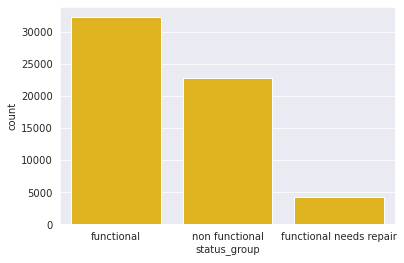

In [4]:

sns.set_style("darkgrid");
sns.set_color_codes(palette='bright');
sns.countplot(x=train['status_group'],color='y');

In [5]:
fig = px.scatter(data_frame=train,y=train['latitude'], x=train['longitude'],color=train['lga'],opacity=0.5
                 )
fig.show()

#hover_name=train['status_group']

The latitude and longitude have data which is outside of tanzania . Replacing those points with the mean of the latitude 
and longitude points. 

In [6]:
df=train.groupby(['extraction_type_class','status_group']).count()['permit'].head(200).reset_index()


fig = px.bar(df, x="extraction_type_class", y="permit",color="status_group", title=" ",width=1000, height=500)

fig.show()

del df

Intresting to note that natural ways of pumps work much more reliable than technologically powered so thinking of group this into 3 types 
gravity , handpump ,submersible and other( other + motorpump+rope_pump+wind-powered)

In [7]:
df=train.groupby(['region','status_group']).count()['permit'].head(200).reset_index()


fig = px.bar(df, x="region", y="permit",color="status_group", title=" ",width=1000, height=500)

fig.show()

del df

In [8]:
df=train.groupby(['lga','status_group']).count()['permit'].head(200).reset_index()


fig = px.bar(df, x="lga", y="permit",color="status_group", title=" ",width=1000, height=500)

fig.show()

del df

In [9]:
#Filling the missing Lattitude and longitude values

index=train[train['longitude']==0].index

train.loc[index,'longitude']=np.nan
train.loc[index,'latitude']=np.nan


mean_longitude=train['longitude'].mean()
mean_latitude=train['latitude'].mean()

train['longitude'].fillna(value=mean_longitude,inplace=True)
train['latitude'].fillna(value=mean_latitude,inplace=True)

#Filling the test dataset 
test_index=test[test['longitude']==0].index

test.loc[test_index,'longitude']=np.nan
test.loc[test_index,'latitude']=np.nan

test['longitude'].fillna(value=mean_longitude,inplace=True)
test['latitude'].fillna(value=mean_latitude,inplace=True)

In [10]:
# Filling the gps_height columns . Google search revals that the entire country of Tanzania lies abouve sea level.
#So the zero in GPS height must be the missing value in the column. Using data from the below site I am gng to fill values by region 
#https://elevation.maplogs.com/poi/tanzania.10739.html 

gps_missing_region=train[train['gps_height']==0]['region'].value_counts().index

train['gps_height'].replace({0:np.nan},inplace=True)
test['gps_height'].replace({0:np.nan},inplace=True)

height={'Shinyanga':1233,'Mbeya':1360,'Kagera':1199, 'Mwanza':1138, 'Dodoma':1741,'Tabora':1177, 'Tanga':458,\
        'Morogoro':254, 'Pwani':258, 'Lindi':317, 'Dar es Salaam':52, 'Mtwara':470}

for region in gps_missing_region:
    train.loc[((train['region']==region) & (train['gps_height'].isnull())),'gps_height']=height[region]
    test.loc[((test['region']==region) & (test['gps_height'].isnull())),'gps_height']=height[region]


In [11]:
#Creating the model 

# Fill Na and group rare groups into one 

train['quality_group'].replace({'salty':'not_good','unknown':'not_good','milky':'not_good','colored':'not_good',
                                  'fluoride':'not_good'},inplace=True)

test['quality_group'].replace({'salty':'not_good','unknown':'not_good','milky':'not_good','colored':'not_good',
                                  'fluoride':'not_good'},inplace=True)


train['permit'].fillna('none',inplace=True)
train['public_meeting'].fillna('none',inplace=True)

test['permit'].fillna('none',inplace=True)
test['public_meeting'].fillna('none',inplace=True)

train['scheme_management'].fillna('None',inplace=True)

train['scheme_management'].replace({'SWC':'VWC','Water authority':'government','Water Board':'government','Parastatal':'government'
                                   ,'Private operator':'private','Company':'private','Other':'private','Trust':'board','WUG':'board',
                                    'WUA':'board'
                                   },inplace=True)

test['scheme_management'].fillna('None',inplace=True)

test['scheme_management'].replace({'SWC':'VWC','Water authority':'government','Water Board':'government','Parastatal':'government'
                                   ,'Private operator':'private','Company':'private','Other':'private','Trust':'board','WUG':'board',
                                    'WUA':'board'
                                   },inplace=True)

train['subvillage'].fillna('none',inplace=True)
test['subvillage'].fillna('none',inplace=True)

#Converting columns to string

train['funder']=train['funder'].astype('str')
train['installer']=train['installer'].astype('str')

test['funder']=test['funder'].astype('str')
test['installer']=test['installer'].astype('str')

#lower casing the funder and installer names 

train['funder']=train['funder'].apply(lambda x:x.lower())
train['installer']=train['installer'].apply(lambda x:x.lower())

train['funder'].replace({'0':'none'},inplace=True)
train['funder'].fillna('none',inplace=True)

train['installer'].replace({'0':'none'},inplace=True)
train['installer'].fillna('none',inplace=True)


test['funder']=test['funder'].apply(lambda x:x.lower())
test['installer']=test['installer'].apply(lambda x:x.lower())

test['funder'].replace({'0':'none'},inplace=True)
test['funder'].fillna('none',inplace=True)

test['installer'].replace({'0':'none'},inplace=True)
test['installer'].fillna('none',inplace=True)


train['extraction_type_class'].replace({'motorpump':'other','rope pump':'other',
                                                                       'wind-powered':'other'},inplace=True)
test['extraction_type_class'].replace({'motorpump':'other','rope pump':'other',
                                                                       'wind-powered':'other'},inplace=True)


#train['construction_year'].replace({0:np.nan},inplace=True)

There are many entries in the funder and installer columns which are similar but spelled differently. I did some manual sampling to correct as many as I can so as to reduce the noise in the dataset and also removed rare catergories in the dataset. 

In [12]:
train['installer']=train['installer'].replace({'government of tanzania':'government','danid':'danida','nethalan':'netherland','unisef':'unicef'
                                        ,'do':'donor','w/':'w','germany republi':'germany','kkt':'kkkt','kkkt chruch':'kkkt','central government':'government'
                                        ,'roman cathoric same':'church','nethe':'netherland','not known':'none','da':'danida',
                                        'rwe/dwe':'dwe','ces (gmbh)':'cse','netherlands':'netherland','private individual':'private',
                                        'priva':'private','ces(gmbh)':'ces','w.b':'wb','fin water':'fini water','lawatefuka water sup':'lawatefuka water supply'
                                        ,'would bank':'world bank','chruc':'chur','british colonial government':'british','canada and tanzania':'government',
                                        'rural water supply and sanitat':'rural water supply and sanitation','central govt':'government','world':'world bank',
                                        'losaa-kia water supp':'losaa-kia water supply','killflora /community':'killflora','finw':'fini water','ministry of water':'government',                   
                                        'oikos e.afrika':'oikos e africa','quick win project /council':'quick win project','rotary i':'rotary',
                                         'local te':'local te','magadini-makiwaru wa':'magadini-makiwaru water','parastatal':'government',
                                        'ruangwa contractor':'private','donor':'private','village council':'village','district council':'district',
                                        'distri':'district','mileniam':'millenium','roman catholic':'church','rc church':'chruch','cartas':'caritas',
                                        'tz japan':'japan','rcchurch/cefa':'church','swedish':'swedan','rc churc':'church','wo':'world bank','rudep/':'rudep',
                                        'cetral government /rc':'government','nyamingu subvillage':'village','tanza':'government','handeni trunk main(':
                                        'handeni trunk main','0':'none','nan':'none','finn water':'fini water','government/ community':'government',
                                        'rwe /community':'rwe' ,'mwaki contractor':'private','gwasco l':'gwasco','village govt':'village',
                                       '\tmagadini-makiwaru water':'magadini-makiwaru water','plan internationa':'plan international',
                                        'village council/ haydom luther':'village','wua':'wu','swiss if':'swiss','mkinga distric cou':'district'
                                    ,'wateraid':'water aid','mwe &':'mwe','individuals':'private','gover':'government','anglican church':'church',
                                     'angli':'church','kkkt_makwale':'kkkt','kkkt _ konde and dwe':'kkkt','happy watoto foundation':'private',
                                      'irish ai':'irish','drdp ngo':'drdp','roman ca':'church','roman':'church','ministry of education':
                                    'government','sekei village community':'village','local technician':'private','tabora municipal council':
                                    'district','clause workers':'clause','bank':'world bank','desk c':'private','desk and chair foundation':
                                    'private','ministry of water engineer':'government','mkinga distric coun':'district','koberg contractor':'private',
                                    'roman cathoric-same':'chruch','adra /government':'government','world vision/ kkkt':'world vision','hw/rc':'church',
                                      'adra /community':'adra','sengerema water department':'district','tasaf/tlc':'tasaf','olgilai village community':'village',
                                      'china government':'china','chinese':'china','village government':'village','finwater':'fini water','rural water supply and sanitation':'village',
                                   'institutional':'private','the people of japan':'japan','hesawz':'hesawa','tasaf and lga':'district','cipro/government':'government','kkkt church':'kkkt',
                                       'plan internatio':'plan international','schoo':'school','songea district coun':'songea district council',
                                'regwa company of egypt':'egypt','regwa company':'egypt','us embassy':'usa','lga':'district','hotels and loggs tz ltd':'private',
                                  'the desk and chair foundat':'the desk and chair foundation','game fronti':'game frontier',
                                  'oikos e.africa/european union':'oikos e africa','oikos e .africa':'oikos e africa','african':'oikos e africa',
                                'finland':'fini water','i.e.c':'iec','isf/government':'government','roman catholic rulenge diocese':'church',
                                 'w.d &':'wd','isf/tacare':'isf','ubalozi wa japani':'japan','cipro/care/tcrs':'tcrs','lutheran':'church','mkinga distric cou':
                                'district','villagers':'village','rc ch':'church','rc':'church','unice':'unicef','world vision/adra':'world vision',
                                 'unicef/central':'unicef','karumba biulding contractor':'private','songea district council'  :'distict','district water department':'district',
                                  'saxon building contractor':'private','j mal abdallah':'jamal abdallah','finida german tanzania govt':'government', 
                                    'rural water supply and sanita':'village','winnin spirit co ltd':'private','water aid/sema':'water aid','pr':'private','tasaf/':'tasaf' 
                                     ,'dokta mwandulami':'dokta mwandulam' ,'dr. matobola':'private','dwe}':'dwe','water aid /sema':'water aid','doner and com':'private',
                                              'a/co germany':'germany','churc':'church','aco/germany':'germany','rc church/centr':'church','cental government':'government',
                                        'villagers mpi':'village','udc/sema':'sema','china henan contractor':'china','tcrs /government':'government','communit':'community',
                                       'church of disciples':'church','adra/ community':'adra','village authority':'village','uniceffinida german tanzani':'unicef','uniceffinidagermantanzania':'unicef',
                                      'w0rld  bank':'world bank','villager':'village','old bank':'world bank','village gover':'village','village committee':'village','village fou':'village',
                                      'village gover':'village','the desk and chair foundati':'private','tz/japan embass':'government','tanzania na egypt':'government',
                                      'tanzania christian service':'government','tanzania na egypt':'government','tanzania nea egypt':'government','tasaf/village community':'village','unise':'unicef',
                                      'swedish tandala project':'sweden','rcchurch':'church','othodox church':'church','private company':'private','private manager':'private',
                                      'tanzania/australia':'government','wise-usa':'usa','tober and friends from austral':'australia','tz/japan embass':'japan','watoto foundation':'private',
                                      'ubalozi wa marekani/dwe':'dwe','tag church vi':'church','school administration':'school','school capital':'school','sinohydro':'china','daids':'dandia','danida /wsdp':'dandia',
                                      'heaswa':'heasawa','kkkt church s':'kkkt','lga and the commu':'lga','chruch':'church','dwe/norad':'dwe','fw':'fini water','ga':'germany','gen':'germany',
                                      'plan int':'plan international','ridep':'redep','tasaf':'tassaf','the desk and chair foundation':'private','ru':'rudep','peter tesha':'peters','md':'mdrdp',
                                      'local  technician':'local','local contract':'local','local te':'local','muwsa':'muwasa','oxfam':'oxfarm','finland government finland gov':'fini water',
                                      'government/julius':'government','kkkt imbaseny':'kkkt','kkkt kolila':'kkkt','kkkt mso':'kkkt','lgsp/dwe':'dwe','mosque bugula':'mosque','mosque pera':'mosque','water of water':'water',
                                      'romam catholc/vil':'church'})


test['installer']=test['installer'].replace({'government of tanzania':'government','danid':'danida','nethalan':'netherland','unisef':'unicef'
                        ,'do':'donor','w/':'w','germany republi':'germany','kkt':'kkkt','kkkt chruch':'kkkt','central government':'government'
                        ,'roman cathoric same':'church','nethe':'netherland','not known':'none','da':'danida',
                        'rwe/dwe':'dwe','ces (gmbh)':'cse','netherlands':'netherland','private individual':'private',
                        'priva':'private','ces(gmbh)':'ces','w.b':'wb','fin water':'fini water','lawatefuka water sup':'lawatefuka water supply'
                        ,'would bank':'world bank','chruc':'chur','british colonial government':'british','canada and tanzania':'government',
                        'rural water supply and sanitat':'rural water supply and sanitation','central govt':'government','world':'world bank',
                        'losaa-kia water supp':'losaa-kia water supply','killflora /community':'killflora','finw':'fini water','ministry of water':'government',                   
                         'oikos e.afrika':'oikos e africa','quick win project /council':'quick win project','rotary i':'rotary',
                         'local te':'local te','magadini-makiwaru wa':'magadini-makiwaru water','parastatal':'government',
                        'ruangwa contractor':'private','donor':'private','village council':'village','district council':'district',
                          'distri':'district','mileniam':'millenium','roman catholic':'church','rc church':'chruch','cartas':'caritas',
                           'tz japan':'japan','rcchurch/cefa':'church','swedish':'swedan','rc churc':'church','wo':'world bank','rudep/':'rudep',
                    'cetral government /rc':'government','nyamingu subvillage':'village','tanza':'government','handeni trunk main(':
                    'handeni trunk main','0':'none','nan':'none','finn water':'fini water','government/ community':'government',
                       'rwe /community':'rwe' ,'mwaki contractor':'private','gwasco l':'gwasco','village govt':'village',
                       '\tmagadini-makiwaru water':'magadini-makiwaru water','plan internationa':'plan international',
                        'village council/ haydom luther':'village','wua':'wu','swiss if':'swiss','mkinga distric cou':'district'
                        ,'wateraid':'water aid','mwe &':'mwe','individuals':'private','gover':'government','anglican church':'church',
                         'angli':'church','kkkt_makwale':'kkkt','kkkt _ konde and dwe':'kkkt','happy watoto foundation':'private',
                          'irish ai':'irish','drdp ngo':'drdp','roman ca':'church','roman':'church','ministry of education':
                            'government','sekei village community':'village','local technician':'private','tabora municipal council':
                                'district','clause workers':'clause','bank':'world bank','desk c':'private','desk and chair foundation':
                                    'private','ministry of water engineer':'government','mkinga distric coun':'district','koberg contractor':'private',
                            'roman cathoric-same':'chruch','adra /government':'government','world vision/ kkkt':'world vision','hw/rc':'church',
                              'adra /community':'adra','sengerema water department':'district','tasaf/tlc':'tasaf','olgilai village community':'village',
                              'china government':'china','chinese':'china','village government':'village','finwater':'fini water','rural water supply and sanitation':'village',
                               'institutional':'private','the people of japan':'japan','hesawz':'hesawa','tasaf and lga':'district','cipro/government':'government','kkkt church':'kkkt',
                               'plan internatio':'plan international','schoo':'school','songea district coun':'songea district council',
                            'regwa company of egypt':'egypt','regwa company':'egypt','us embassy':'usa','lga':'district','hotels and loggs tz ltd':'private',
                              'the desk and chair foundat':'the desk and chair foundation','game fronti':'game frontier',
                              'oikos e.africa/european union':'oikos e africa','oikos e .africa':'oikos e africa','african':'oikos e africa',
                                'finland':'fini water','i.e.c':'iec','isf/government':'government','roman catholic rulenge diocese':'church',
                                 'w.d &':'wd','isf/tacare':'isf','ubalozi wa japani':'japan','cipro/care/tcrs':'tcrs','lutheran':'church','mkinga distric cou':
                                'district','villagers':'village','rc ch':'church','rc':'church','unice':'unicef','world vision/adra':'world vision',
                                 'unicef/central':'unicef','karumba biulding contractor':'private','songea district council'  :'distict','district water department':'district',
                                  'saxon building contractor':'private','j mal abdallah':'jamal abdallah','finida german tanzania govt':'government', 
                                    'rural water supply and sanita':'village','winnin spirit co ltd':'private','water aid/sema':'water aid','pr':'private','tasaf/':'tasaf' 
                                     ,'dokta mwandulami':'dokta mwandulam' ,'dr. matobola':'private','dwe}':'dwe','water aid /sema':'water aid','doner and com':'private',
                                              'a/co germany':'germany','churc':'church','aco/germany':'germany','rc church/centr':'church','cental government':'government',
                                        'villagers mpi':'village','udc/sema':'sema','china henan contractor':'china','tcrs /government':'government','communit':'community',
                                       'church of disciples':'church','adra/ community':'adra','village authority':'village','uniceffinida german tanzani':'unicef','uniceffinidagermantanzania':'unicef',
                                      'w0rld  bank':'world bank','villager':'village','old bank':'world bank','village gover':'village','village committee':'village','village fou':'village',
                                      'village gover':'village','the desk and chair foundati':'private','tz/japan embass':'government','tanzania na egypt':'government',
                                      'tanzania christian service':'government','tanzania na egypt':'government','tanzania nea egypt':'government','tasaf/village community':'village','unise':'unicef',
                                      'swedish tandala project':'sweden','rcchurch':'church','othodox church':'church','private company':'private','private manager':'private',
                                      'tanzania/australia':'government','wise-usa':'usa','tober and friends from austral':'australia','tz/japan embass':'japan','watoto foundation':'private',
                                      'ubalozi wa marekani/dwe':'dwe','tag church vi':'church','school administration':'school','school capital':'school','sinohydro':'china','daids':'dandia','danida /wsdp':'dandia',
                                      'heaswa':'heasawa','kkkt church s':'kkkt','lga and the commu':'lga','chruch':'church','dwe/norad':'dwe','fw':'fini water','ga':'germany','gen':'germany',
                                      'plan int':'plan international','ridep':'redep','tasaf':'tassaf','the desk and chair foundation':'private','ru':'rudep','peter tesha':'peters','md':'mdrdp',
                                      'local  technician':'local','local contract':'local','local te':'local','muwsa':'muwasa','oxfam':'oxfarm','finland government finland gov':'fini water',
                                      'government/julius':'government','kkkt imbaseny':'kkkt','kkkt kolila':'kkkt','kkkt mso':'kkkt','lgsp/dwe':'dwe'})

In [13]:
train['funder']=train['funder'].replace({'government of tanzania':'government','danid':'danida','nethalan':'netherland','unisef':'unicef'
                        ,'do':'donor','w/':'w','germany republi':'germany','kkt':'kkkt','kkkt chruch':'kkkt','central government':'government'
                        ,'roman cathoric same':'church','nethe':'netherland','not known':'none','da':'danida',
                        'rwe/dwe':'dwe','ces (gmbh)':'cse','netherlands':'netherland','private individual':'private',
                        'priva':'private','ces(gmbh)':'ces','w.b':'wb','fin water':'fini water','lawatefuka water sup':'lawatefuka water supply'
                        ,'would bank':'world bank','chruc':'chur','british colonial government':'british','canada and tanzania':'government',
                        'rural water supply and sanitat':'rural water supply and sanitation','central govt':'government','world':'world bank',
                        'losaa-kia water supp':'losaa-kia water supply','killflora /community':'killflora','finw':'fini water','ministry of water':'government',                   
                         'oikos e.afrika':'oikos e africa','quick win project /council':'quick win project','rotary i':'rotary',
                         'local te':'local te','magadini-makiwaru wa':'magadini-makiwaru water','parastatal':'government',
                        'ruangwa contractor':'private','donor':'private','village council':'village','district council':'district',
                          'distri':'district','mileniam':'millenium','roman catholic':'church','rc church':'chruch','cartas':'caritas',
                           'tz japan':'japan','rcchurch/cefa':'church','swedish':'swedan','rc churc':'church','wo':'world bank','rudep/':'rudep',
                    'cetral government /rc':'government','nyamingu subvillage':'village','tanza':'government','handeni trunk main(':
                    'handeni trunk main','0':'none','nan':'none','finn water':'fini water','government/ community':'government',
                       'rwe /community':'rwe' ,'mwaki contractor':'private','gwasco l':'gwasco','village govt':'village',
                       '\tmagadini-makiwaru water':'magadini-makiwaru water','plan internationa':'plan international',
                        'village council/ haydom luther':'village','wua':'wu','swiss if':'swiss','mkinga distric cou':'district'
                        ,'wateraid':'water aid','mwe &':'mwe','individuals':'private','gover':'government','anglican church':'church',
                         'angli':'church','kkkt_makwale':'kkkt','kkkt _ konde and dwe':'kkkt','happy watoto foundation':'private',
                          'irish ai':'irish','drdp ngo':'drdp','roman ca':'church','roman':'church','ministry of education':
                            'government','sekei village community':'village','local technician':'private','tabora municipal council':
                                'district','clause workers':'clause','bank':'world bank','desk c':'private','desk and chair foundation':
                                    'private','ministry of water engineer':'government','mkinga distric coun':'district','koberg contractor':'private',
                            'roman cathoric-same':'chruch','adra /government':'government','world vision/ kkkt':'world vision','hw/rc':'church',
                              'adra /community':'adra','sengerema water department':'district','tasaf/tlc':'tasaf','olgilai village community':'village',
                              'china government':'china','chinese':'china','village government':'village','finwater':'fini water','rural water supply and sanitation':'village',
                               'institutional':'private','the people of japan':'japan','hesawz':'hesawa','tasaf and lga':'district','cipro/government':'government','kkkt church':'kkkt',
                               'plan internatio':'plan international','schoo':'school','songea district coun':'songea district council',
                            'regwa company of egypt':'egypt','regwa company':'egypt','us embassy':'usa','lga':'district','hotels and loggs tz ltd':'private',
                              'the desk and chair foundat':'the desk and chair foundation','game fronti':'game frontier',
                              'oikos e.africa/european union':'oikos e africa','oikos e .africa':'oikos e africa','african':'oikos e africa',
                                'finland':'fini water','i.e.c':'iec','isf/government':'government','roman catholic rulenge diocese':'church',
                                 'w.d &':'wd','isf/tacare':'isf','ubalozi wa japani':'japan','cipro/care/tcrs':'tcrs','lutheran':'church','mkinga distric cou':
                                'district','villagers':'village','rc ch':'church','rc':'church','unice':'unicef','world vision/adra':'world vision',
                                 'unicef/central':'unicef','karumba biulding contractor':'private','songea district council'  :'distict','district water department':'district',
                                  'saxon building contractor':'private','j mal abdallah':'jamal abdallah','finida german tanzania govt':'government', 
                                    'rural water supply and sanita':'village','winnin spirit co ltd':'private','water aid/sema':'water aid','pr':'private','tasaf/':'tasaf' 
                                     ,'dokta mwandulami':'dokta mwandulam' ,'dr. matobola':'private','dwe}':'dwe','water aid /sema':'water aid','doner and com':'private',
                                              'a/co germany':'germany','churc':'church','aco/germany':'germany','rc church/centr':'church','cental government':'government',
                                        'villagers mpi':'village','udc/sema':'sema','china henan contractor':'china','tcrs /government':'government','communit':'community',
                                       'church of disciples':'church','adra/ community':'adra','village authority':'village','uniceffinida german tanzani':'unicef','uniceffinidagermantanzania':'unicef',
                                      'w0rld  bank':'world bank','villager':'village','old bank':'world bank','village gover':'village','village committee':'village','village fou':'village',
                                      'village gover':'village','the desk and chair foundati':'private','tz/japan embass':'government','tanzania na egypt':'government',
                                      'tanzania christian service':'government','tanzania na egypt':'government','tanzania nea egypt':'government','tasaf/village community':'village','unise':'unicef',
                                      'swedish tandala project':'sweden','rcchurch':'church','othodox church':'church','private company':'private','private manager':'private',
                                      'tanzania/australia':'government','wise-usa':'usa','tober and friends from austral':'australia','tz/japan embass':'japan','watoto foundation':'private',
                                      'ubalozi wa marekani/dwe':'dwe','tag church vi':'church','school administration':'school','school capital':'school','sinohydro':'china','daids':'dandia','danida /wsdp':'dandia',
                                      'heaswa':'heasawa','kkkt church s':'kkkt','lga and the commu':'lga','chruch':'church','dwe/norad':'dwe','fw':'fini water','ga':'germany','gen':'germany',
                                      'plan int':'plan international','ridep':'redep','tasaf':'tassaf','the desk and chair foundation':'private','ru':'rudep','peter tesha':'peters','md':'mdrdp',
                                      'local  technician':'local','local contract':'local','local te':'local','muwsa':'muwasa','oxfam':'oxfarm','finland government finland gov':'fini water',
                                      'government/julius':'government','kkkt imbaseny':'kkkt','kkkt kolila':'kkkt','kkkt mso':'kkkt','lgsp/dwe':'dwe','mosque bugula':'mosque','mosque pera':'mosque','water of water':'water',
                                      'romam catholc/vil':'church'})


test['funder']=test['funder'].replace({'government of tanzania':'government','danid':'danida','nethalan':'netherland','unisef':'unicef'
                        ,'do':'donor','w/':'w','germany republi':'germany','kkt':'kkkt','kkkt chruch':'kkkt','central government':'government'
                        ,'roman cathoric same':'church','nethe':'netherland','not known':'none','da':'danida',
                        'rwe/dwe':'dwe','ces (gmbh)':'cse','netherlands':'netherland','private individual':'private',
                        'priva':'private','ces(gmbh)':'ces','w.b':'wb','fin water':'fini water','lawatefuka water sup':'lawatefuka water supply'
                        ,'would bank':'world bank','chruc':'chur','british colonial government':'british','canada and tanzania':'government',
                        'rural water supply and sanitat':'rural water supply and sanitation','central govt':'government','world':'world bank',
                        'losaa-kia water supp':'losaa-kia water supply','killflora /community':'killflora','finw':'fini water','ministry of water':'government',                   
                         'oikos e.afrika':'oikos e africa','quick win project /council':'quick win project','rotary i':'rotary',
                         'local te':'local te','magadini-makiwaru wa':'magadini-makiwaru water','parastatal':'government',
                        'ruangwa contractor':'private','donor':'private','village council':'village','district council':'district',
                          'distri':'district','mileniam':'millenium','roman catholic':'church','rc church':'chruch','cartas':'caritas',
                           'tz japan':'japan','rcchurch/cefa':'church','swedish':'swedan','rc churc':'church','wo':'world bank','rudep/':'rudep',
                    'cetral government /rc':'government','nyamingu subvillage':'village','tanza':'government','handeni trunk main(':
                    'handeni trunk main','0':'none','nan':'none','finn water':'fini water','government/ community':'government',
                       'rwe /community':'rwe' ,'mwaki contractor':'private','gwasco l':'gwasco','village govt':'village',
                       '\tmagadini-makiwaru water':'magadini-makiwaru water','plan internationa':'plan international',
                        'village council/ haydom luther':'village','wua':'wu','swiss if':'swiss','mkinga distric cou':'district'
                        ,'wateraid':'water aid','mwe &':'mwe','individuals':'private','gover':'government','anglican church':'church',
                         'angli':'church','kkkt_makwale':'kkkt','kkkt _ konde and dwe':'kkkt','happy watoto foundation':'private',
                          'irish ai':'irish','drdp ngo':'drdp','roman ca':'church','roman':'church','ministry of education':
                            'government','sekei village community':'village','local technician':'private','tabora municipal council':
                                'district','clause workers':'clause','bank':'world bank','desk c':'private','desk and chair foundation':
                                    'private','ministry of water engineer':'government','mkinga distric coun':'district','koberg contractor':'private',
                            'roman cathoric-same':'chruch','adra /government':'government','world vision/ kkkt':'world vision','hw/rc':'church',
                              'adra /community':'adra','sengerema water department':'district','tasaf/tlc':'tasaf','olgilai village community':'village',
                              'china government':'china','chinese':'china','village government':'village','finwater':'fini water','rural water supply and sanitation':'village',
                               'institutional':'private','the people of japan':'japan','hesawz':'hesawa','tasaf and lga':'district','cipro/government':'government','kkkt church':'kkkt',
                               'plan internatio':'plan international','schoo':'school','songea district coun':'songea district council',
                            'regwa company of egypt':'egypt','regwa company':'egypt','us embassy':'usa','lga':'district','hotels and loggs tz ltd':'private',
                              'the desk and chair foundat':'the desk and chair foundation','game fronti':'game frontier',
                              'oikos e.africa/european union':'oikos e africa','oikos e .africa':'oikos e africa','african':'oikos e africa',
                                'finland':'fini water','i.e.c':'iec','isf/government':'government','roman catholic rulenge diocese':'church',
                                 'w.d &':'wd','isf/tacare':'isf','ubalozi wa japani':'japan','cipro/care/tcrs':'tcrs','lutheran':'church','mkinga distric cou':
                                'district','villagers':'village','rc ch':'church','rc':'church','unice':'unicef','world vision/adra':'world vision',
                                 'unicef/central':'unicef','karumba biulding contractor':'private','songea district council'  :'distict','district water department':'district',
                                  'saxon building contractor':'private','j mal abdallah':'jamal abdallah','finida german tanzania govt':'government', 
                                    'rural water supply and sanita':'village','winnin spirit co ltd':'private','water aid/sema':'water aid','pr':'private','tasaf/':'tasaf' 
                                     ,'dokta mwandulami':'dokta mwandulam' ,'dr. matobola':'private','dwe}':'dwe','water aid /sema':'water aid','doner and com':'private',
                                              'a/co germany':'germany','churc':'church','aco/germany':'germany','rc church/centr':'church','cental government':'government',
                                        'villagers mpi':'village','udc/sema':'sema','china henan contractor':'china','tcrs /government':'government','communit':'community',
                                       'church of disciples':'church','adra/ community':'adra','village authority':'village','uniceffinida german tanzani':'unicef','uniceffinidagermantanzania':'unicef',
                                      'w0rld  bank':'world bank','villager':'village','old bank':'world bank','village gover':'village','village committee':'village','village fou':'village',
                                      'village gover':'village','the desk and chair foundati':'private','tz/japan embass':'government','tanzania na egypt':'government',
                                      'tanzania christian service':'government','tanzania na egypt':'government','tanzania nea egypt':'government','tasaf/village community':'village','unise':'unicef',
                                      'swedish tandala project':'sweden','rcchurch':'church','othodox church':'church','private company':'private','private manager':'private',
                                      'tanzania/australia':'government','wise-usa':'usa','tober and friends from austral':'australia','tz/japan embass':'japan','watoto foundation':'private',
                                      'ubalozi wa marekani/dwe':'dwe','tag church vi':'church','school administration':'school','school capital':'school','sinohydro':'china','daids':'dandia','danida /wsdp':'dandia',
                                      'heaswa':'heasawa','kkkt church s':'kkkt','lga and the commu':'lga','chruch':'church','dwe/norad':'dwe','fw':'fini water','ga':'germany','gen':'germany',
                                      'plan int':'plan international','ridep':'redep','tasaf':'tassaf','the desk and chair foundation':'private','ru':'rudep','peter tesha':'peters','md':'mdrdp',
                                      'local  technician':'local','local contract':'local','local te':'local','muwsa':'muwasa','oxfam':'oxfarm','finland government finland gov':'fini water',
                                      'government/julius':'government','kkkt imbaseny':'kkkt','kkkt kolila':'kkkt','kkkt mso':'kkkt','lgsp/dwe':'dwe','mosque bugula':'mosque','mosque pera':'mosque','water of water':'water',
                                      'romam catholc/vil':'church'})

In [14]:
#Combining the rare values in funders and installers columns into one group to redcuce noise 

Funder=set(train['funder'].value_counts().tail(1631).index)

for funder in Funder:
    train['funder'].replace({funder:'rare_field'},inplace=True)
    test['funder'].replace({funder:'rare_field'},inplace=True)
#print('Funder Done')
    
Installer=set(train['installer'].value_counts().tail(1648).index)

for installer in Installer:
    train['installer'].replace({installer:'rare_field'},inplace=True)
    test['installer'].replace({installer:'rare_field'},inplace=True)
#print('Installer Done')
    
Ward=set(train['ward'].value_counts().tail(1891).index)

for ward in Ward:
    train['ward'].replace({ward:'rare_field'},inplace=True)
    test['ward'].replace({ward:'rare_field'},inplace=True)
#print('Ward Done')  

village=set(train['subvillage'].value_counts().tail(18384).index) #95 percentile 

for v in village:
    train['subvillage'].replace({v:'rare_field'},inplace=True)
    test['subvillage'].replace({v:'rare_field'},inplace=True)
#print('subvillage Done')  

In [15]:
del Funder 
del village
del Installer
del Ward

In [16]:
#Remving values where are unique in test set and replacing them with rare_field

for col in ['funder','installer','subvillage','ward']:
    for v in set(test[col]).symmetric_difference(set(train[col])):
        test[col].replace({v:'rare_field'},inplace=True)
                                                   
                                                   

In [17]:
#Creating new columns 



train['location']=(train['region'].astype(str)
                   +"_"+
                   train['lga'].astype(str)
                  )

test['location']=(test['region'].astype(str)
                   +"_"+
                   test['lga'].astype(str)
                  )


train['quality_quantity']=(train['quality_group'].astype(str)
                   +"_"+
                   train['quantity'].astype(str)
                  )

test['quality_quantity']=(test['quality_group'].astype(str)
                   +"_"+
                   test['quantity'].astype(str)
                  )

In [18]:
train['ext_type_class_year']=(train['extraction_type_class'].astype(str)
                   +"_"+
                   train['construction_year'].astype(str)
                  )

test['ext_type_class_year']=(test['extraction_type_class'].astype(str)
                   +"_"+
                   test['construction_year'].astype(str)
                  )


In [19]:

ext_type_class_year=set(train['ext_type_class_year'].value_counts().tail(54).index)

for v in ext_type_class_year:
    train['ext_type_class_year'].replace({v:'rare_field'},inplace=True)
    test['ext_type_class_year'].replace({v:'rare_field'},inplace=True)
#print('ext_type_class_year Done')
    
    
for col in ['ext_type_class_year']:
    for v in set(test[col]).symmetric_difference(set(train[col])):
        test[col].replace({v:'rare_field'},inplace=True)

### Checking Feature importance 

Seeing mutual scores I was able to conclude that the new features added 

In [20]:

from sklearn.feature_selection import mutual_info_classif

discrete_features=[ 'permit', 'management_group',
       'source_class', 'public_meeting', 'quality_group', 'scheme_management',
       'payment', 'extraction_type_class', 'quantity', 'waterpoint_type_group',
       'region', 'lga', 'ward', 'subvillage', 'funder', 'installer',
       'construction_year', 'location',
        'quality_quantity','ext_type_class_year']

X=train.copy()

for col in discrete_features:
    X[col],_=X[col].factorize()

X=X.drop(['status_group','folds'],axis=1)
y,_=train['status_group'].factorize()

mi_scores=mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores",index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores

quality_quantity         0.109086
quantity                 0.105684
ext_type_class_year      0.097935
location                 0.088668
lga                      0.087544
installer                0.068571
longitude                0.066919
funder                   0.065303
ward                     0.061515
latitude                 0.061225
waterpoint_type_group    0.053165
extraction_type_class    0.052675
region                   0.043024
subvillage               0.039761
construction_year        0.035786
payment                  0.035002
gps_height               0.025418
scheme_management        0.015788
quality_group            0.011319
management_group         0.003893
public_meeting           0.003777
source_class             0.003172
permit                   0.000000
Name: MI Scores, dtype: float64

### Model Fitting 

In [21]:
from category_encoders import TargetEncoder
import xgboost as xgb
from sklearn import preprocessing, metrics 
import random 
import warnings 
import lightgbm as lgb

warnings.filterwarnings('ignore')

def run(fold=5,model_num=15):
    
    
    
    #Converting all columns to string 

    for column in categorical+['location','quality_quantity','ext_type_class_year']:
        
        train.loc[:,column]=train[column].astype(str)
        if(column!='status_group'):
            test.loc[:,column]=test[column].astype(str)

        

    #label_encoding=[col for col in categorical if col not in ['funder','installer','ward','subvillage','region','lga']]
    
    for column in categorical+['location','quality_quantity','ext_type_class_year']:
        lb=preprocessing.LabelEncoder()
        lb.fit(train[column])
        train.loc[:,column]=lb.transform(train[column])
        
        
        if( column!='status_group'): 
            test.loc[:,column]=lb.transform(test[column])
    
    
    
    
    
    model_list=[0]*model_num
    prediction=np.zeros((test.shape[0],2*model_num*fold))
    col=0
    
    print('******XGB Model******')
    
    for i in np.arange(model_num):
        
        
        print(f"model no:{i}")
        
        for fold in np.arange(5):
            
            
            
            df_train=train[train['folds']!=fold].reset_index(drop=True)
            df_valid=train[train['folds']==fold].reset_index(drop=True)
    
            model_xgb = xgb.XGBClassifier(objective ='multi:softmax', num_class=3 ,colsample_bytree =0.6,
                                        learning_rate = 0.15, max_depth = 10, alpha = 0.8,
                                        n_estimators = 200,eval_metric='merror',nthread=-1,
                                        subsample=0.8, verbosity=0,use_label_encoder=False
                                        ,scale_pos_weight= 4,random_state=random.randint(10, 10000))
    
            model_xgb.fit(df_train.drop(['status_group','folds'],axis=1),df_train['status_group'])
    
            train_preds=model_xgb.predict(df_train.drop(['status_group','folds'],axis=1))
            valid_preds=model_xgb.predict(df_valid.drop(['status_group','folds'],axis=1))
        
            
    
            train_accuracy=metrics.accuracy_score(df_train['status_group'],train_preds)
    
            valid_accuracy=metrics.accuracy_score(df_valid['status_group'],valid_preds)
            
            prediction[:,col]=model_xgb.predict(test.drop(['id'],axis=1))
            
        
    
            print(f"fold={fold},train_accuracy={train_accuracy},valid_accuracy={valid_accuracy}")
        
            
            col=col+1
    
    ### Add Light GBM here too 
    print('******Light GBM Model******')
    
    for i in np.arange(model_num):
        
        
        print(f"model no:{i}")
        
        for fold in np.arange(5):            
            
            df_train=train[train['folds']!=fold].reset_index(drop=True)
            df_valid=train[train['folds']==fold].reset_index(drop=True)
    
            model_lgb = lgb.LGBMClassifier(objective ='multiclass', num_class=3,learning_rate= 0.12,lambda_l1= 0.22,
                                           num_leaves= 184, max_depth= 74,min_data_in_leaf=5, feature_fraction= 0.52,  
                                           bagging_fraction= 0.85,bagging_freq= 7,boosting_type= 'gbdt',
                                            random_state=random.randint(10, 10000),verbose=-1)
    
            model_lgb.fit(df_train.drop(['status_group','folds'],axis=1),df_train['status_group'])
    
            train_preds=model_lgb.predict(df_train.drop(['status_group','folds'],axis=1))
            valid_preds=model_lgb.predict(df_valid.drop(['status_group','folds'],axis=1))
        
            
    
            train_accuracy=metrics.accuracy_score(df_train['status_group'],train_preds)
    
            valid_accuracy=metrics.accuracy_score(df_valid['status_group'],valid_preds)

            prediction[:,col]=model_lgb.predict(test.drop(['id'],axis=1))
            
        
    
            print(f"fold={fold},train_accuracy={train_accuracy},valid_accuracy={valid_accuracy}")
        
            
            col=col+1
        
    return prediction

In [22]:
predictions=run()

******XGB Model******
model no:0
fold=0,train_accuracy=0.9292087542087543,valid_accuracy=0.8055555555555556
fold=1,train_accuracy=0.9291245791245791,valid_accuracy=0.8042087542087543
fold=2,train_accuracy=0.9278198653198653,valid_accuracy=0.8041245791245791
fold=3,train_accuracy=0.9298821548821549,valid_accuracy=0.8033670033670034
fold=4,train_accuracy=0.9293560606060606,valid_accuracy=0.8058922558922559
model no:1
fold=0,train_accuracy=0.929040404040404,valid_accuracy=0.8071548821548822
fold=1,train_accuracy=0.9294402356902357,valid_accuracy=0.8015151515151515
fold=2,train_accuracy=0.9301978114478114,valid_accuracy=0.8052188552188552
fold=3,train_accuracy=0.9320917508417509,valid_accuracy=0.803030303030303
fold=4,train_accuracy=0.9281355218855218,valid_accuracy=0.806986531986532
model no:2
fold=0,train_accuracy=0.9304082491582492,valid_accuracy=0.8056397306397306
fold=1,train_accuracy=0.9302188552188552,valid_accuracy=0.7994107744107745
fold=2,train_accuracy=0.930324074074074,valid_ac

In [23]:
from scipy import stats
test['status_group']=stats.mode(predictions,axis=1)[0]

test['status_group'].replace({0.0:'functional',2.0:'non functional',1.0:'functional needs repair'},inplace=True)

test[['id','status_group']].to_csv('./Xgboost_lightGBM_ensemble_fold_random.csv',index=False)

So to summarize I have used two GBM model Light GBM and XGboost and fine tuned them using Optuna and RandomsearchCV 

After that I have I have combined the two model to generate prediction on the test set which gets me 0.8147 private LB score.The topper for the competition is at 0.8245. 

## The End 

### Fine Tune Light GMB using Optuna 

In [24]:
#import lightgbm as lgb

#from category_encoders import TargetEncoder
#import xgboost as xgb
#from sklearn import preprocessing, metrics 
#import random 
#import warnings 
#import optuna 

#def pre_process(train=train,test=test):
    
    
    
    #Converting all columns to string 

    #for column in categorical+['location','quality_quantity','ext_type_class_year']:
        
        #train.loc[:,column]=train[column].astype(str)
        #if(column!='status_group'):
            #test.loc[:,column]=test[column].astype(str)
    
    #for column in categorical+['location','quality_quantity','ext_type_class_year']:
        #lb=preprocessing.LabelEncoder()
        #lb.fit(train[column])
        #train.loc[:,column]=lb.transform(train[column])
        
        
        #if( column!='status_group'): 
            #test.loc[:,column]=lb.transform(test[column])

        
    #return train, test

#train,test=pre_process(train=train,test=test)


#def d_train_test(fold,train,test):
    
    
    
    #df_train=train[train['folds']!=fold].reset_index(drop=True)
    #df_valid=train[train['folds']==fold].reset_index(drop=True)
    
    #train_data=lgb.Dataset(df_train.drop(['status_group','folds'],axis=1),label=df_train['status_group'])
    
    
    #return train_data,df_valid.drop(['status_group','folds'],axis=1),df_valid['status_group'],test


        

#def objective(trial,train_set=train,test_set=test):
    
    #param = {
        #'objective': 'multiclass',
        #'num_class':3,
        #'verbosity': -1,
        #'boosting_type': 'gbdt',
        #'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.8),
        #'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        #'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        #'max_depth':trial.suggest_int('max_depth',10,100),
        #'min_data_in_leaf':trial.suggest_int('min_data_in_leaf',5,150),
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        #'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    #}
    
    #accuracy_list=[]
    
    #for v in np.arange(5):
        #X_train,X_valid,y_valid,test=d_train_test(v,train_set,test_set)
    

        #gbm = lgb.train(param, X_train)
        #predictions=gbm.predict(X_valid).argmax(axis=1)
        #accuracy_list.append(metrics.accuracy_score(y_valid,predictions))
        
    #accuracy=np.mean(accuracy_list)
    
    

    #return accuracy

# Run the optuna study 

#study = optuna.create_study(direction='maximize',study_name='Light GBM optimization')
#study.optimize(objective, n_trials=200)


### Fine  tuning XGboost using Random search CV 

In [25]:
#from category_encoders import TargetEncoder
#import xgboost as xgb
#from sklearn import preprocessing
#import warnings 

#warnings.filterwarnings('ignore')

#def get_data():
    
    #Converting all columns to string 

    #for columns in categorical:
        #train.loc[:,columns]=train[columns].astype(str)
        

    #label_encoding=[col for col in categorical if col not in ['funder','installer','ward','subvillage','region','lga','construction_year','location']]
    
    #for column in label_encoding:
        #lb=preprocessing.LabelEncoder()
        
        #lb.fit(train[column])
        
        #train.loc[:,column]=lb.transform(train[column])
 
    
    #Target encoder 
    
    #for column in ['funder','installer','funder','installer','ward','subvillage','region','lga','construction_year','location']:
        #encoder = TargetEncoder(min_samples_leaf=1)
        #encoder.fit(train[column], train['status_group'])
        #train.loc[:,column] =encoder.transform(train[column])
         
    
    #return train.drop(['status_group','folds'],axis=1),train['status_group']

In [26]:
#from sklearn.model_selection import RandomizedSearchCV
#import numpy as np 
#import xgboost as xgb

#params = {
        #'learning_rate': np.arange(0,0.3,0.05),
       #'n_estimators':np.arange(50,250,50),
       #'subsample':np.arange(0,1.2,0.2),
        #'gamma': [0.5, 1, 1.5, 2, 5],
       #'colsample_bytree': np.arange(0.4,1,0.2),
       # 'max_depth': np.arange(5,15,5),
       # 'reg_alpha':np.arange(0.5,1,0.5),
        #'scale_pos_weight':np.arange(0,11,2)
       # }

#model = xgb.XGBClassifier(objective='multi:softmax',\
 #                    nthread=1,num_class=3,random_state=7)

#folds = 5
#param_comb = 150

#X,y=get_data()


#kfold = model_selection.StratifiedKFold(n_splits=folds, shuffle = True, random_state = 7)

#random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=kfold.split(X,y), verbose=5, random_state=101,refit=True )


#random_search.fit(X, y)

#print("The best score is {}".format(random_search.best_score_ ))

#print('/n')

#print ('The best paramerts are {}'.format(random_search.best_params_))


###  Reading Resources 

https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/


#np.percentile(train['ext_type_class_year'].value_counts(),25)